In [ ]:
# Solve problem 5 from Lagaris, Likas, and Fotiadis (1998)
# $(x,y) \in [0,1]^2$
# $$ \Delta \Psi(x,y) = f(x,y), where f(x,y) = e^{-x}(x-2+y^3+6y)$$
# Boundary conditions:
# \Psi(0,y) = y^3
# \Psi(1,y) = (1+y^3)e^{-1}
# \Psi(x,0) = xe^{-x}
# \Psi(x,1) = e^{-1}(x+1)
# Exact solution: \Psi_{exact}(x,y) = e^{-x}(x+y^3)
# Solution model: \Psi(x,y) = A(x,y) + x(1-x)y(1-y)NN(x,y;w)
# where NN(x,y;w) is a neural network of the form NN(x,y) = v * sigma(W*[x,y]^T + v)
# where v is n-by-1, W is n-by-2, v is n-by-1,
# x(1-x)y(1-y) is a function that is zero on the boundary, and 
# A(x,y) is a smooth function satisfying boundary consitions:
# A(x,y) = (1-x)y^3 + x(1+y^3)e^{-1} + (1-y)x(e^{-x}-e^{-1}) + y[(1+x)e^{-x}-(1-x+2xe^{-1})]
# Training points: {(x_i,y_i)}_{i=1}^N
# loss function: L(w) = (1/N)\sum_{i=1}^N (\Psi_{xx}(x_i,y_i) + Psi_{yy}(x_i,y_i) - f(x_i,y_i))^2

In [ ]:
# import necessary packages
import numpy as np
import torch
import matplotlib.pyplot as plt

from optimizers import Adam, GaussNewton, Nesterov
torch.set_default_dtype(torch.float64) # set arithmetic to be double precision
plt.rcParams.update({'font.size': 20}) # set font size in all plots

In [ ]:
# define the exact solution
def ExactSolution(x,y):
    # e^{-x}(x+y^3)
    return torch.exp(-x)*(x+y.pow(3))

In [ ]:
def prepare_data(xmin,xmax,nx,ymin,ymax,ny,strip_bdry):
    x1 = torch.linspace(xmin,xmax,steps = nx)
    y1 = torch.linspace(ymin,ymax,steps = ny)
    if strip_bdry == True:
        grid_x, grid_y = torch.meshgrid(x1[1:nx-1],y1[1:ny-1],indexing = 'ij')
    else:
        grid_x, grid_y = torch.meshgrid(x1,y1,indexing = 'ij')
    xcol = torch.reshape(grid_x,(grid_x.numel(),1))
    ycol = torch.reshape(grid_y,(grid_y.numel(),1))
    data_matrix = torch.cat((xcol,ycol),1)
    return grid_x, grid_y, data_matrix

Text(0.5, 1.0, 'Exact sol. and train pts')

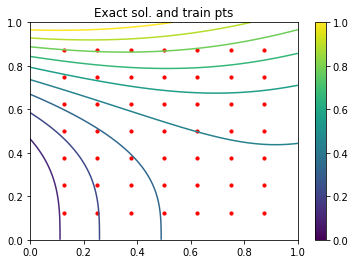

In [ ]:
# define training points
npt1 = 9
strip_boundary = True
xtrain_grid, ytrain_grid, xytrain = prepare_data(0.,1.,npt1,0.,1.,npt1,strip_boundary)

# define test points
npt2 = 100
strip_boundary = False
xtest_grid, ytest_grid, xytest = prepare_data(0.,1.,npt2,0.,1.,npt2,strip_boundary)

# find the exact solution at the test points
sol_exact = ExactSolution(xtest_grid,ytest_grid)
sol_exact_vector = torch.reshape(sol_exact,(torch.numel(sol_exact),1))
sol_min = torch.min(sol_exact_vector)
sol_max = torch.max(sol_exact_vector)

# plot the exact solution and the training points
plt.figure()
plt.contour(xtest_grid,ytest_grid,sol_exact,torch.arange(sol_min,sol_max,(sol_max-sol_min)*0.1))  
plt.scatter(xytrain[:,0],xytrain[:,1],s = 10, c = '#FF0000')
plt.colorbar()
plt.title("Exact sol. and train pts")



In [ ]:
# define activation function
def ActiveFun(x):
    # tanh
    ActFun = torch.tanh(x);
    dActFun = 1/torch.cosh(x).pow(2); # 1./cosh(x).^2
    d2ActFun = -2*torch.sinh(x)/torch.cosh(x).pow(3); # -2*sinh(x)./cosh(x).^3
    d3ActFun = (4*torch.sinh(x).pow(2)-2)/torch.cosh(x).pow(4); # (4*sinh(x).^2-2)./cosh(x).^4
    return ActFun, dActFun, d2ActFun, d3ActFun

In [ ]:
# define solution model
# define our model and call it model_11
N_neurons = 10
# initialize parameters of NN with random numbers
W = torch.rand(N_neurons*4,1)
# architecture: NN(X;w) = w3 * sigma(w0*x + w2*1 + w2)
# w3 is 1-by-N_neurons
# w2 is N_neurons-by-2
# w1 is Nneurons-by-1

def NeuralNetwork(x,y,W,derivatives):
    Nneurons = int((torch.numel(W)/4))
    # print("NN: Nneurons = ",Nneurons)
    W = torch.transpose(torch.reshape(W,(4,Nneurons)),0,1)
    z = W[:,2]+W[:,0]*x+W[:,1]*y # argument of sigma
    s0,s1,s2,s3 = ActiveFun(z) # sigma(z) and its first three derivatives
    # the neural network and its derivatives with respect to x and y
    W3s1 = W[:,3]*s1;
    NN = torch.sum(W[:,3]*s0)
    if derivatives == False:
        return NN
    else:    
        NNx = torch.sum(W3s1*W[:,0])
        NNy = torch.sum(W3s1*W[:,1])
        NNxx = torch.sum(W[:,3]*(W[:,0].pow(2)*s2))
        NNyy = torch.sum(W[:,3]*(W[:,1].pow(2)*s2))
        # derivatives w.r.t. parameters of the neural network 
        NN_W0 = x*W3s1
        NN_W1 = y*W3s1
        NN_W2 = W3s1
        NN_W3 = s0
        NN_W = torch.cat((NN_W0,NN_W1,NN_W2,NN_W3),0) # combine derivatives into a column vector    
        # derivatives w.r.t. parameters of NNx = sum(w3*w0*s1)
        W3W0s2 = W[:,3]*W[:,0]*s2;
        NNx_W0 = W3s1 + W3W0s2*x
        NNx_W1 = W3W0s2*y
        NNx_W2 = W3W0s2
        NNx_W3 = W[:,0]*s1
        NNx_W = torch.cat((NNx_W0,NNx_W1,NNx_W2,NNx_W3),0) # combine derivatives into a column vector
        # derivatives w.r.t. parameters of NNy = sum(w3*w1*s1)
        W3W1s2 = W[:,3]*W[:,1]*s2;
        NNy_W0 = W3W1s2*x
        NNy_W1 = W3s1 + W3W1s2*y
        NNy_W2 = W3W1s2
        NNy_W3 = W[:,1]*s1
        NNy_W = torch.cat((NNy_W0,NNy_W1,NNy_W2,NNy_W3),0) # combine derivatives into a column vector
        # derivatives w.r.t. parameters of NNxx = sum(w3*w0^2*s2)
        W3W0W0s3 = W[:,3]*W[:,0].pow(2)*s3
        NNxx_W0 = 2*W3W0s2 + W3W0W0s3*x
        NNxx_W1 = W3W0W0s3*y
        NNxx_W2 = W3W0W0s3
        NNxx_W3 = W[:,0].pow(2)*s2
        NNxx_W = torch.cat((NNxx_W0,NNxx_W1,NNxx_W2,NNxx_W3),0) # combine derivatives into a column vector
        # derivatives w.r.t. parameters of NNyy = sum(w3*w1^2*s2)
        W3W1W1s3 = W[:,3]*W[:,1].pow(2)*s3
        NNyy_W0 = W3W1W1s3*x
        NNyy_W1 = 2*W3W1s2 + W3W1W1s3*y
        NNyy_W2 = W3W1W1s3
        NNyy_W3 = W[:,1].pow(2)*s2
        NNyy_W = torch.cat((NNyy_W0,NNyy_W1,NNyy_W2,NNyy_W3),0) # combine derivatives into a column vector
        return NN, NNx, NNy, NNxx, NNyy, NN_W, NNx_W, NNy_W, NNxx_W, NNyy_W
    
def SolutionModel(x,y,W):
    # u(x,y) = A(x,y) + x(1-x)y(1-y)NN(x,y;w), where
    # A(x,y) = (1-x)y^3 + x(1+y^3)e^{-1} + (1-y)x(e^{-x}-e^{-1}) + y[(1+x)e^{-x}-(1-x+2xe^{-1})]
    NN = NeuralNetwork(x,y,W,False)
    em1 = torch.tensor(np.exp(-1.0))
    emx = torch.exp(-x)
    A1 = (1-x)*y.pow(3)
    A2 = x*(1+y.pow(3))*em1
    A3 = (1-y)*x*(emx-em1)
    A4 = y*((1+x)*emx-(1-x+2*x*em1))
    A = A1+A2+A3+A4
    B = x*(1-x)*y*(1-y)
    sol = A+B*NN
    return sol

def RHS(x,y):
    return torch.exp(-x)*(x-2+y.pow(3)+6*y)


def PoissonEqSolutionModel(x,y,W):
    # computes the r = Laplacian[A(x,y) + x(1-x)y(1-y)NN(x,y;w)] - RightHandSide
    # and the gradient of r w.r.t parameters W
    NN, NNx, NNy, NNxx, NNyy, NN_W, NNx_W, NNy_W, NNxx_W, NNyy_W = NeuralNetwork(x,y,W,True)
    em1 = torch.tensor(np.exp(-1.0))
    emx = torch.exp(-x)
    Axx = (x + y - 2)*emx
    Ayy = 6*y*(1 - x + x*em1)
    B1 = x*(1-x)
    B1x = 1-2*x
    B1xx = -2.
    B2 = y*(1-y)
    B2y = 1-2*y
    B2yy = -2.
    uxx = Axx + B2*(B1*NNxx + 2*B1x*NNx + B1xx*NN)
    uyy = Ayy + B1*(B2*NNyy + 2*B2y*NNy + B2yy*NN)
    res = uxx + uyy - RHS(x,y)
    dres_W = (B2*B1xx + B1*B2yy)*NN_W + 2*(B2*B1x*NNx_W + B1*B2y*NNy_W) + B2*B1*(NNxx_W + NNyy_W)
    return res, dres_W

In [ ]:
# form the vector of residuals and the Jacobian matrix for the set of training points
def Residual_and_Jacobian(xy,W):
    # each row of xy corresponds to a training point
    Nxy = xy.size(dim=0) # the number of training points
    NW = W.numel() # total number of entries of W
   # print(NW)
    res = torch.zeros(Nxy,1) # vector of residuals
    Jac = torch.zeros(Nxy,NW) # Jacobian matrix
   # print(xy)
    for j in range(Nxy):
       
        r,dr_W = PoissonEqSolutionModel(xy[j,0],xy[j,1],W)
        res[j] = r
        Jac[j,:] = dr_W
    return res, Jac    

In [ ]:
# Levenverg-Marquardt
def Loss(r):
    return 0.5*torch.sum(r.pow(2)) # 0.5*sum(r^2)
    
def LevenbergMarquardt(Res_and_Jac,par,x):
    # minimizes loss = 0.5/n sum_{j=1}^n r_j^2(x)
    # constrained minimization problem solved at each step:
    # m(p) = grad^\top p + 0.5 p^\top Bmatr p --> min
    # subject to R - ||p|| >= 0
    # rho = [loss - loss(x + p)] / [loss - m(p)]
    
    # parameters for Levengerg-Marquardt
    RMAX = 1.;
    RMIN = 1e-12;
    RHO_GOOD = 0.75 # increase R is rho > RHO_GOOD
    RHO_BAD = 0.25 # decrease R is rho < RHO_BAD
    ETA = 0.01 # reject step if rho < ETA 
    ITER_MAX = 100
    TOL = 1.0e-3 # terminate when || grad loss || < tol
    
    # initialization
    r,J = Res_and_Jac(par,x)
    print(J.size())
    # print(r.size())
    # print(J.size())
    n = J.size(dim = 0) # the number of components of r
    d = J.size(dim = 1) # the number of variables
    
    lossvals = torch.zeros(ITER_MAX)
    gradnormvals = torch.zeros(ITER_MAX)
    lossvals[0] = Loss(r)
    Jtrans = torch.transpose(J,0,1)
    grad = torch.matmul(Jtrans,r) # grad = J^\top r
    Bmatr = torch.matmul(Jtrans,J) # Bmatr = J^\top J
    gradnorm = torch.linalg.norm(grad)
    gradnormvals[0] = gradnorm
    R = 0.2*RMAX # initial trust region radius
    print("iter 0: loss = ",lossvals[0]," gradnorm = ",gradnorm)
    # start iterations
    iter = 1
    while gradnorm > TOL and iter < ITER_MAX:
        # print(Jtrans.size())
        # print(J.size())
        # print(torch.eye(d).size())
        # print(torch.matmul(Jtrans,J).size())
        Bmatr = torch.matmul(Jtrans,J) # B = J^\top J
        p = -torch.linalg.lstsq(Bmatr,grad).solution # p = -Bmatr^{-1}grad
        norm_p = torch.linalg.norm(p)
        if norm_p > R:
            # solve grad^\top p + 0.5 p^\top Bmatr p --> min
            # subject to ||p|| = R
            gap = torch.abs(norm_p - R)
            iter_lam = 0
            lam_tol = 0.01*R
            lam = 1 # initial guess for lambda in the 1D constrained minimization problems
            while gap > lam_tol:
                B1 = Bmatr + lam*torch.eye(d) 
                C = torch.linalg.cholesky(B1) # B1 = C C^\top
                p = -torch.linalg.solve_triangular(torch.transpose(C,0,1), \
                     torch.linalg.solve_triangular(C,grad,upper = False),upper = True)
                norm_p = torch.linalg.norm(p)
                gap = torch.abs(norm_p - R)
                if gap > lam_tol:
                    q = torch.linalg.solve_triangular(C,p,upper = False)
                    norm_q = torch.linalg.norm(q)
                    lamnew = lam + (norm_p/norm_q).pow(2)*(norm_p-R)/R
                    if lamnew < 0:
                        lam = 0.5*lam
                    else:
                        lam = lamnew
                    iter_lam = iter_lam + 1
                    gap = torch.abs(norm_p - R)
            print("LM, iter ",iter,":", iter_lam," substeps")
        else:
            print("LM, iter ",iter,": steps to the model's minimum")
        # evaluate the progres
        # print("size of x: ",x.size())
        # print("size of p: ",p.size())
        xnew = x + p
        # print("size of xnew: ",xnew.size())
        rnew,Jnew = Res_and_Jac(par,xnew)  
        # print("rnew: ",rnew.size())
        # print("Jnew: ",Jnew.size())
        lossnew = Loss(rnew)
        rho = -(lossvals[iter-1] - lossnew)/(torch.sum(grad*p) + 0.5*sum(p*torch.matmul(Bmatr,p)))   
        # adjust the trust region radius
        print(rho)
        if rho < RHO_BAD:
            R = torch.max(torch.tensor([RMIN,0.25*R]))
        elif rho > RHO_GOOD:
            R = torch.min(torch.tensor([RMAX,2.0*R]))                                       
        # accept or reject the step
        if rho > ETA:
            x = xnew
            r = rnew
            J = Jnew  
            Jtrans = torch.transpose(J,0,1)
            grad = torch.matmul(Jtrans,r)                                       
            gradnorm = torch.linalg.norm(grad)
        lossvals[iter] = lossnew
        gradnormvals[iter] = gradnorm
        print("LM, iter ",iter,": loss = ",lossvals[iter]," gradnorm = ",gradnorm," rho = ",rho," R = ",R)
        iter = iter + 1                                           
    return x,iter,lossvals[0:iter], gradnormvals[0:iter]          


def linesearch(r, w, aux,d, a, gamma):
    f0 = Loss(r)
    f1 = f0+a*aux+1
    kmax = np.ceil(np.log(1e-14)/np.log(gamma))
    k = 0
    while(f1 > f0+a*aux and k < kmax):
        wtry = w + a*d;
        f1 = Loss(r)
        a = a*gamma


Iter  0 : loss =  tensor(71.7035)  gradnorm =  tensor(65.8860)
Iter  1 : loss =  tensor(0.)  gradnorm =  tensor(nan)


Text(0.5, 0, 'iter number')

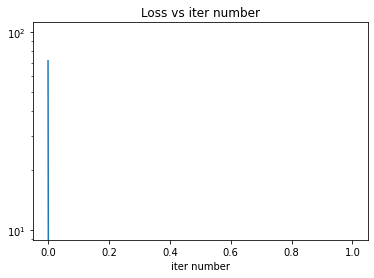

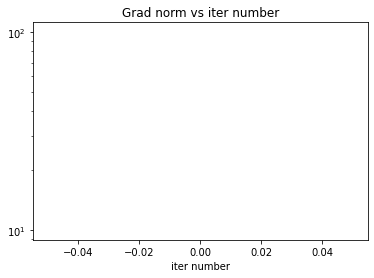

In [ ]:



optimizer = GaussNewton(Loss,Residual_and_Jacobian,W,xytrain,50)

W,Niter,lossvals,gradnormvals = optimizer.minimize()#Adam(Residual_and_Jacobian,xytrain,W)
# plot the loss and the norm of the gradient of the loss
plt.figure()
plt.plot(torch.arange(Niter),lossvals)
plt.title("Loss vs iter number")
plt.yscale("log")
plt.xlabel("iter number")
plt.figure()
plt.plot(np.arange(Niter),gradnormvals)
plt.title("Grad norm vs iter number")
plt.yscale("log")
plt.xlabel("iter number")

Max error =  tensor(0.7396)
Mean error =  tensor(0.2551)
RMS error =  tensor(0.3364)


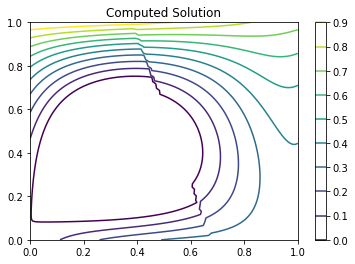

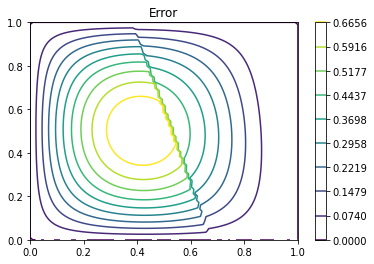

In [ ]:
# test the solution
sol_test = torch.zeros(npt2,npt2)
Ntest = torch.numel(sol_test)
for i in range(npt2):
    for j in range(npt2):
        sol_test[i,j] = SolutionModel(xtest_grid[i,j],ytest_grid[i,j],W)
plt.figure()
plt.contour(xtest_grid,ytest_grid,sol_test,torch.arange(sol_min,sol_max,0.1*(sol_max-sol_min)))   
plt.colorbar()
plt.title("Computed Solution")
# compare with the exact solution
error = torch.abs(sol_test - sol_exact)
error_vector = torch.reshape(error,(Ntest,1))
error_max = torch.max(error_vector)
plt.figure()
plt.contour(xtest_grid,ytest_grid,error,torch.arange(0.,error_max,error_max*0.1))  
plt.colorbar()
plt.title("Error")
print("Max error = ",torch.max(error_vector))
print("Mean error = ",torch.mean(error_vector))
print("RMS error = ",torch.sqrt(torch.mean(error_vector.pow(2))))